<a href="https://colab.research.google.com/github/Alba251/face_detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Alba251/face_detection.git
%cd face_detection


Cloning into 'face_detection'...
remote: Enumerating objects: 5016, done.
remote: Counting objects: 100% (5016/5016), done.
remote: Compressing objects: 100% (5014/5014), done.
remote: Total 5016 (delta 4), reused 5003 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5016/5016), 32.68 MiB | 13.27 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/face_detection


In [2]:
#LIBRERIAS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tqdm import tqdm


In [3]:
data = pd.read_csv("./data/data.csv", sep=';', dtype={'gender': str})
data.head()

FileNotFoundError: [Errno 2] No such file or directory: './data/data.csv'

In [16]:
print(data.describe(include = "all"))

         im_name  gender  left_eye_x  left_eye_y  right_eye_x  right_eye_y  \
count       5000    5000  5000.00000  5000.00000   5000.00000  5000.000000   
unique      5000       2         NaN         NaN          NaN          NaN   
top     4999.jpg  female         NaN         NaN          NaN          NaN   
freq           1    2884         NaN         NaN          NaN          NaN   
mean         NaN     NaN    69.39320   111.18780    107.60540   111.144200   
std          NaN     NaN     1.73931     1.12338      1.70689     1.179866   
min          NaN     NaN    60.00000   104.00000     93.00000   100.000000   
25%          NaN     NaN    68.00000   111.00000    107.00000   111.000000   
50%          NaN     NaN    69.00000   111.00000    108.00000   111.000000   
75%          NaN     NaN    70.00000   112.00000    109.00000   112.000000   
max          NaN     NaN    86.00000   117.00000    114.00000   122.000000   

                age  
count   5000.000000  
unique          NaN

In [17]:
#Conertimos la columan de male, female a binario

data['gender'] = data['gender'].map({'male':1, 'female':0})
data.head()


,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,1,70,111,107,111,37
1,1.jpg,1,71,110,106,111,31
2,2.jpg,1,71,111,106,110,37
3,3.jpg,1,68,111,108,112,51
4,4.jpg,1,71,111,106,110,36


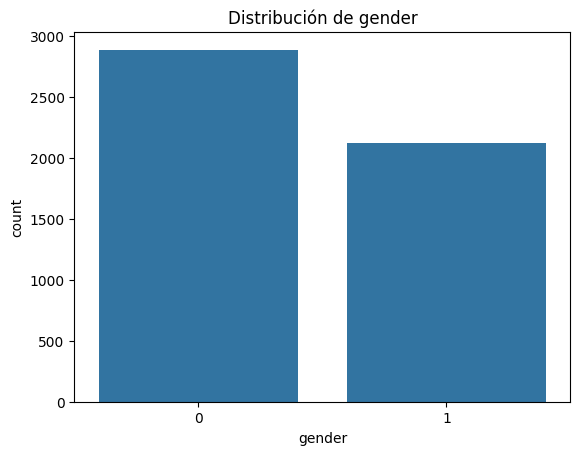

In [18]:
 #Ahora analizaremos cada variable
sns.countplot(x='gender', data=data)
plt.title("Distribución de gender")
plt.show()

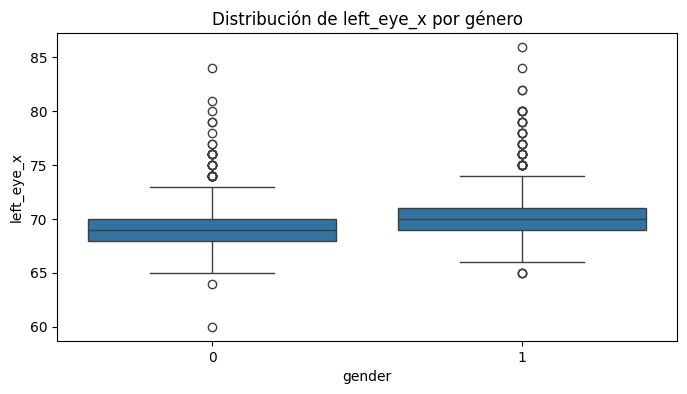

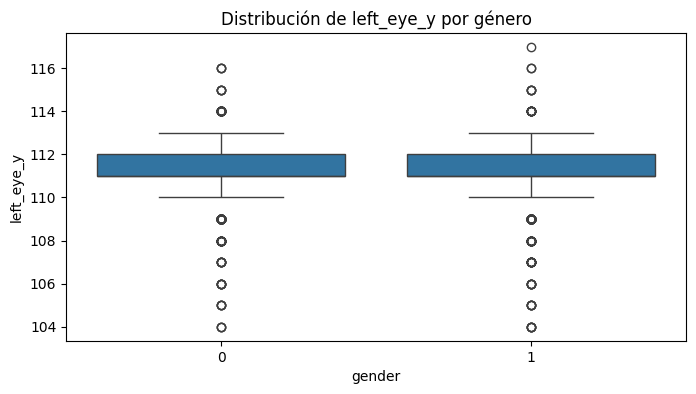

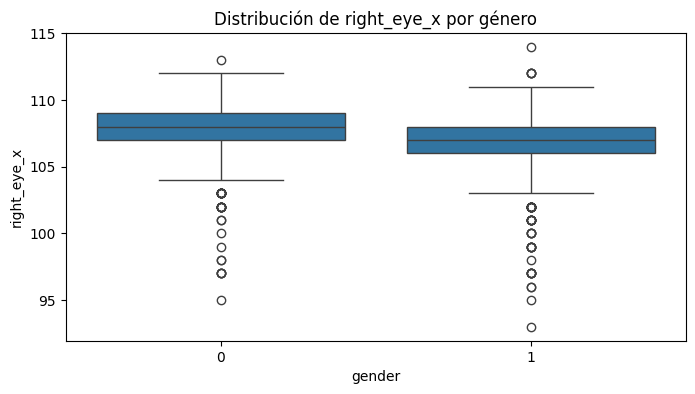

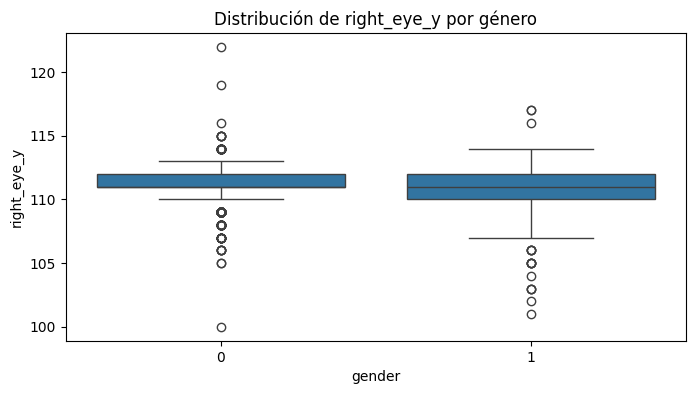

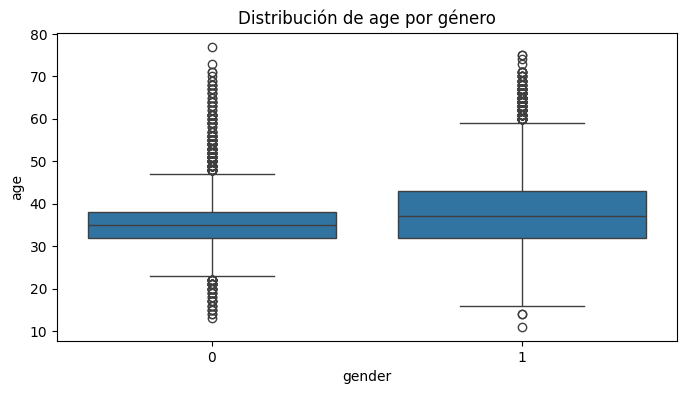

In [ ]:
numerical_cols = ['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y', 'age']

for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='gender', y=col, data=data)
    plt.title(f'Distribución de {col} por género')
    plt.show()

#Tenemos resultados muy diferentes, lo que tiene sentido pq la persona puede estar desplazada...

In [19]:
#Vamos a normalizar los datos de la posicon de los ojos para poder redimensionalizar las imagenes a 224x224

data['left_eye_x'] = data['left_eye_x'] / 178.0
data['right_eye_x'] = data['right_eye_x'] / 178.0
data['left_eye_y'] = data['left_eye_y'] / 218.0
data['right_eye_y'] = data['right_eye_y'] / 218.0
data['age'] = data['age'] / 100.0  # suponiendo que la mayoría no pasa de 100 años


data.head()

,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,1,0.393258,0.509174,0.601124,0.509174,0.37
1,1.jpg,1,0.398876,0.504587,0.595506,0.509174,0.31
2,2.jpg,1,0.398876,0.509174,0.595506,0.504587,0.37
3,3.jpg,1,0.382022,0.509174,0.606742,0.513761,0.51
4,4.jpg,1,0.398876,0.509174,0.595506,0.504587,0.36


In [1]:
#ampliamso el dataset rotando en 90º, 180º, 270º, pasando de 5000 a 20000 imagenes

# Función para cargar y procesar la imagen
def load_and_preprocess_image(filename):
    img_path = os.path.join("data/images/", filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # normaliza [0,1]
    image = tf.image.resize(image, [224, 224])  # 🔁 Resize importante
    return image

def rotate_and_adjust(image, eyes, angle):
    lx, ly, rx, ry = eyes
    if angle == 90:
        img = tf.image.rot90(image, k=1)
        lx_, ly_ = ly, 1 - lx
        rx_, ry_ = ry, 1 - rx
    elif angle == 180:
        img = tf.image.rot90(image, k=2)
        lx_, ly_ = 1 - lx, 1 - ly
        rx_, ry_ = 1 - rx, 1 - ry
    elif angle == 270:
        img = tf.image.rot90(image, k=3)
        lx_, ly_ = 1 - ly, lx
        rx_, ry_ = 1 - ry, rx
    else:
        img = image
        lx_, ly_, rx_, ry_ = lx, ly, rx, ry
    return img.numpy(), [lx_, ly_, rx_, ry_]

# Dataset aumentado
X_all, y_all = [], []
angles = [0, 90, 180, 270]

for idx, row in tqdm(data.iterrows(), total=len(data)):
    try:
        image = load_and_preprocess_image(row['im_name'])
        gender = row['gender']
        age = row['age']
        eyes = [row['left_eye_x'], row['left_eye_y'], row['right_eye_x'], row['right_eye_y']]
        for angle in angles:
            img_rot, eyes_rot = rotate_and_adjust(image, eyes, angle)
            X_all.append(img_rot)
            y_all.append([gender, age] + eyes_rot)
    except Exception as e:
        print(f"Error con {row['im_name']}: {e}")

X_all = np.array(X_all, dtype=np.float32)
y_all = np.array(y_all, dtype=np.float32)

NameError: name 'tqdm' is not defined

In [20]:
#DIVIDIMOS EL DATASET EN TRAIN, TEST, VALIDATE

# Paso 1: dividir primero en train + temp (val+test)
images_train, images_temp, genders_train, genders_temp, ages_train, ages_temp, eyes_train, eyes_temp = train_test_split(
    data['im_name'],
    data['gender'],
    data['age'],
    data[['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y']],
    test_size=0.3,
    stratify=data['gender'],
    random_state=42
)

# Paso 2: dividir temp en val y test (mitad y mitad)
images_val, images_test, genders_val, genders_test, ages_val, ages_test, eyes_val, eyes_test = train_test_split(
    images_temp,
    genders_temp,
    ages_temp,
    eyes_temp,
    test_size=0.5,
    stratify=genders_temp,
    random_state=42
)


In [21]:
### Relacionar datos con imagenes para preparar el input del modelo



# Dataset de TensorFlow que yield (imagen, etiquetas)
def tf_data_generator(images, genders, ages, eyes):
    for i in range(len(images)):
        img = load_and_preprocess_image(images.iloc[i])  # usa .iloc si son pandas Series
        gender = genders.iloc[i]
        age = ages.iloc[i]
        eye_pos = eyes.iloc[i].values  # ojo que eyes es DataFrame, pasamos a array
        labels = {
            'gender': gender,
            'age': age,
            'eye_pos': eye_pos
        }
        yield img, labels

def create_tf_dataset(images, genders, ages, eyes):
    return tf.data.Dataset.from_generator(
        lambda: tf_data_generator(images, genders, ages, eyes),
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            {
                'gender': tf.TensorSpec(shape=(), dtype=tf.float32),
                'age': tf.TensorSpec(shape=(), dtype=tf.float32),
                'eye_pos': tf.TensorSpec(shape=(4,), dtype=tf.float32),
            }
        )
    )

train_dataset = create_tf_dataset(images_train, genders_train, ages_train, eyes_train)
val_dataset = create_tf_dataset(images_val, genders_val, ages_val, eyes_val)
test_dataset = create_tf_dataset(images_test, genders_test, ages_test, eyes_test)

#AÑADE BATCH Y PREFETCH PARA MEJORAR EL RENDIMIENTO
BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Forzar una pequeña iteración para probar el generador
for img, label in train_dataset.take(5):
    pass  # solo itera, el print ya está en load_and_preprocess_image




In [22]:
# Input layer
input_img = Input(shape=(224, 224, 3))

# Backbone CNN preentrenada
base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binaria)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

# Output 2: Age (regresión)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regresión 4 valores)
eye_output = Dense(4, name='eye_pos')(x)

# Modelo final
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)


<ipython-input-22-d419e6434ce9>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')


In [23]:
#ENTRENAMOS EL MODELO

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(images_train) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)



Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 78s 266ms/step - age_loss: 0.2101 - age_mae: 0.3005 - eye_pos_loss: 0.1589 - eye_pos_mae: 0.2572 - gender_accuracy: 0.8375 - gender_loss: 0.3354 - loss: 0.7044 - val_age_loss: 15.3296 - val_age_mae: 3.8458 - val_eye_pos_loss: 9.2185 - val_eye_pos_mae: 2.8047 - val_gender_accuracy: 0.7160 - val_gender_loss: 2.2085 - val_loss: 26.7566
Epoch 2/10
  1/109 ━━━━━━━━━━━━━━━━━━━━ 34:05 19s/step - age_loss: 0.0320 - age_mae: 0.1566 - eye_pos_loss: 0.0074 - eye_pos_mae: 0.0698 - gender_accuracy: 0.9167 - gender_loss: 0.3960 - loss: 0.4354

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - age_loss: 0.0320 - age_mae: 0.1566 - eye_pos_loss: 0.0074 - eye_pos_mae: 0.0698 - gender_accuracy: 0.9167 - gender_loss: 0.3960 - loss: 0.4354 - val_age_loss: 15.5036 - val_age_mae: 3.8665 - val_eye_pos_loss: 8.9081 - val_eye_pos_mae: 2.7356 - val_gender_accuracy: 0.6821 - val_gender_loss: 2.7165 - val_loss: 27.1282
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - age_loss: 0.0101 - age_mae: 0.0784 - eye_pos_loss: 0.0072 - eye_pos_mae: 0.0668 - gender_accuracy: 0.9546 - gender_loss: 0.1134 - loss: 0.1307 - val_age_loss: 7.3771 - val_age_mae: 2.6191 - val_eye_pos_loss: 13.1951 - val_eye_pos_mae: 3.4407 - val_gender_accuracy: 0.9103 - val_gender_loss: 0.5531 - val_loss: 21.1253
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - age_loss: 0.0214 - age_mae: 0.1164 - eye_pos_loss: 0.0110 - eye_pos_mae: 0.0763 - gender_accuracy: 1.0000 - gender_loss: 0.0793 - loss: 0.1117 - val_age_loss: 7.2129 - val_age_mae: 2.5845 - val_eye_pos_loss:

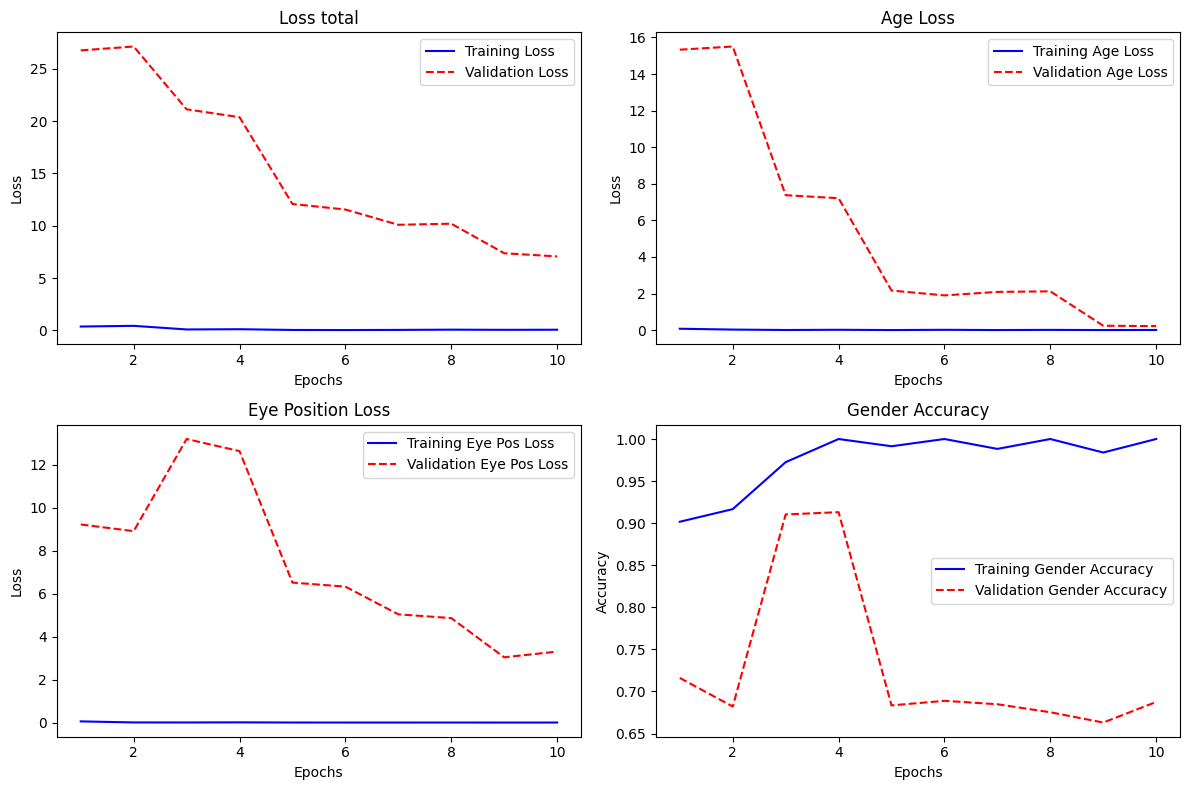

In [24]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot loss total vs val_loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.title('Loss total')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot age_loss vs val_age_loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['age_loss'], 'b-', label='Training Age Loss')
    plt.plot(epochs, history.history['val_age_loss'], 'r--', label='Validation Age Loss')
    plt.title('Age Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot eye_pos_loss vs val_eye_pos_loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['eye_pos_loss'], 'b-', label='Training Eye Pos Loss')
    plt.plot(epochs, history.history['val_eye_pos_loss'], 'r--', label='Validation Eye Pos Loss')
    plt.title('Eye Position Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot gender_accuracy vs val_gender_accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['gender_accuracy'], 'b-', label='Training Gender Accuracy')
    plt.plot(epochs, history.history['val_gender_accuracy'], 'r--', label='Validation Gender Accuracy')
    plt.title('Gender Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llamar a la función con tu objeto history
plot_training_history(history)
